# PROCESO ETL 
Proceso ETL con datos de migración de extranjeros en Colombia, que podría servir a las entidades del estado para crear estrategias y tomar decisiones oportunas.

### importar las librerias que se van a utilizar

In [1]:
import pandas as pd
from arcgis.gis import GIS
from pathlib import Path
from zipfile import ZipFile
from arcgis.features import FeatureLayer
import numpy as np

pd.options.display.max_rows = 10

### Los datos fueron tomados del repositorio de datos abiertos

https://www.datos.gov.co/Estad-sticas-Nacionales/Entradas-de-extranjeros-a-Colombia/96sh-4v8d

Se descargaron los archivos csv y se ubicaron en la misma carpeta del proyecto.

Posteriormente se convierten los datos a un DataFrame de pandas.



In [2]:
df = pd.read_csv("Entradas_de_extranjeros_a_Colombia.csv",dtype={'Nueva columna georreferenciada':'str'})
df=df.dropna(axis=0, subset=['Nueva columna georreferenciada'])
df=df[df['Nacionalidad'] == 'Venezuela']
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356)
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794)
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486)
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479)
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675)
...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317)
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013)
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188)
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396)


### Aplicación de funciones lambda
Con el fin de Limpiar las coordenadas, quitando la palabra ‘POINT’ 

In [3]:
lonlat=(df
           .apply(lambda row: row['Nueva columna georreferenciada'],axis=1)
           .apply(lambda word: word.replace('POINT (',''))
           .apply(lambda body: list(body))
           .apply(lambda letters: list(map(lambda letter:letter.replace(")",''),letters)))
           .apply(lambda letters: ''.join(letters))
              )            

df['lat long']=lonlat
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada,lat long
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356),0.81488 -77356
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794),10406342 -75527794
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486),10446304 -75516486
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479),10886686 -74776479
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675),11117206 -74232675
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317),7128047 -73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013),7819 -72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188),7927233 -72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396),836068 -72409396


In [4]:
df.iloc[18]

Año                                                     2012
Mes                                                  Febrero
Nacionalidad                                       Venezuela
Femenino                                                   0
Masculino                                                  3
Indefinido                                               NaN
Total                                                      3
Nueva columna georreferenciada    POINT (-4191162 -69941498)
lat long                                  -4191162 -69941498
Name: 1883, dtype: object

### Separar latitud y longitud
Tener dos columnas para cada coordenada

In [5]:
latlon_df = df['lat long'].apply(lambda x: pd.Series(x.split(' ')))
df['latt']=latlon_df[0]
df['lonn']=latlon_df[1]
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada,lat long,latt,lonn
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356),0.81488 -77356,0.81488,-77356
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794),10406342 -75527794,10406342,-75527794
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486),10446304 -75516486,10446304,-75516486
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479),10886686 -74776479,10886686,-74776479
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675),11117206 -74232675,11117206,-74232675
...,...,...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317),7128047 -73181317,7128047,-73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013),7819 -72453013,7819,-72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188),7927233 -72508188,7927233,-72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396),836068 -72409396,836068,-72409396


### Eliminar la columna lat long
Ya que no se va a utilizar

In [6]:
df=df.drop(['lat long', 'Nueva columna georreferenciada'], axis=1)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,latt,lonn
907,2012,Enero,Venezuela,297,339,NaN,636,0.81488,-77356
908,2012,Enero,Venezuela,7,12,NaN,19,10406342,-75527794
909,2012,Enero,Venezuela,76,133,NaN,209,10446304,-75516486
910,2012,Enero,Venezuela,55,70,NaN,125,10886686,-74776479
911,2012,Enero,Venezuela,0,4,NaN,4,11117206,-74232675
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,7128047,-73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,7819,-72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,7927233,-72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,836068,-72409396


### Eliminar campos vacios
Pueden generar errores en la ubicación de los puntos

In [7]:
df=df.dropna(axis=0, subset=['latt'])
df=df.dropna(axis=0, subset=['lonn'])
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,latt,lonn
907,2012,Enero,Venezuela,297,339,NaN,636,0.81488,-77356
908,2012,Enero,Venezuela,7,12,NaN,19,10406342,-75527794
909,2012,Enero,Venezuela,76,133,NaN,209,10446304,-75516486
910,2012,Enero,Venezuela,55,70,NaN,125,10886686,-74776479
911,2012,Enero,Venezuela,0,4,NaN,4,11117206,-74232675
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,7128047,-73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,7819,-72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,7927233,-72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,836068,-72409396


## Ubicar el punto

In [8]:
long=df['lonn']
df['long']=0
for i in range(1734):
     df['long'].iloc[i]=(long.iloc[i])[0:3]+'.'+(long.iloc[i])[3:]
df

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,latt,lonn,long
907,2012,Enero,Venezuela,297,339,NaN,636,0.81488,-77356,-77.356
908,2012,Enero,Venezuela,7,12,NaN,19,10406342,-75527794,-75.527794
909,2012,Enero,Venezuela,76,133,NaN,209,10446304,-75516486,-75.516486
910,2012,Enero,Venezuela,55,70,NaN,125,10886686,-74776479,-74.776479
911,2012,Enero,Venezuela,0,4,NaN,4,11117206,-74232675,-74.232675
...,...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,7128047,-73181317,-73.181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,7819,-72453013,-72.453013
67655,2019,Junio,Venezuela,12,28,NaN,40,7927233,-72508188,-72.508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,836068,-72409396,-72.409396


## ...

In [9]:
lat=df['latt']
df['lat']=0
for i in range(1734):
    if (lat.iloc[i])[0]=='1':
        df['lat'].iloc[i]=(lat.iloc[i])[0:2]+'.'+(lat.iloc[i])[2:]
    elif (lat.iloc[i])[0]=='-':
        df['lat'].iloc[i]=(lat.iloc[i])[1:2]+'.'+(lat.iloc[i])[2:]
    elif (lat.iloc[i])[0]=='0':
        df['lat'].iloc[i]=(lat.iloc[i])[0:1]+'.'+(lat.iloc[i])[2:]
    else:
        df['lat'].iloc[i]=(lat.iloc[i])[0:1]+'.'+(lat.iloc[i])[1:]        


## Eliminar columnas 

In [10]:
df= df.drop(columns=['latt', 'lonn'], axis=1)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,long,lat
907,2012,Enero,Venezuela,297,339,NaN,636,-77.356,0.81488
908,2012,Enero,Venezuela,7,12,NaN,19,-75.527794,10.406342
909,2012,Enero,Venezuela,76,133,NaN,209,-75.516486,10.446304
910,2012,Enero,Venezuela,55,70,NaN,125,-74.776479,10.886686
911,2012,Enero,Venezuela,0,4,NaN,4,-74.232675,11.117206
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,-73.181317,7.128047
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,-72.453013,7.819
67655,2019,Junio,Venezuela,12,28,NaN,40,-72.508188,7.927233
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,-72.409396,8.36068


## ...

In [11]:
df[['long','lat']] = df[['long','lat']].apply(pd.to_numeric)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,long,lat
907,2012,Enero,Venezuela,297,339,NaN,636,-77.356000,0.814880
908,2012,Enero,Venezuela,7,12,NaN,19,-75.527794,10.406342
909,2012,Enero,Venezuela,76,133,NaN,209,-75.516486,10.446304
910,2012,Enero,Venezuela,55,70,NaN,125,-74.776479,10.886686
911,2012,Enero,Venezuela,0,4,NaN,4,-74.232675,11.117206
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,-73.181317,7.128047
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,-72.453013,7.819000
67655,2019,Junio,Venezuela,12,28,NaN,40,-72.508188,7.927233
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,-72.409396,8.360680


In [12]:
df.dtypes

Año               int64
Mes              object
Nacionalidad     object
Femenino          int64
Masculino         int64
Indefinido      float64
Total             int64
long            float64
lat             float64
dtype: object

## CSV

In [13]:
df.to_csv('venezuelafinal2.csv', sep=',', encoding='utf-8')

In [14]:
df2 = pd.DataFrame(pd.read_csv("venezuelafinal.csv"))
df2.dtypes

Unnamed: 0        int64
Año               int64
Mes              object
Nacionalidad     object
Femenino        float64
Masculino       float64
Indefinido      float64
Total           float64
long            float64
lat             float64
dtype: object

## Conexión con ArcGis online
por medio de la cuenta de ArcGis Online establecer la conexión 

In [ ]:
gis = GIS("https://www.arcgis.com", username="rcmartinb")

## Propiedades del archivo csv
Se publica el archivo csv 

In [ ]:
venezuela_properties = {
    'title': 'Venezolanos',
    'tags': ['migracion1','migracion2'],
    'type': 'CSV'
}
venezuela_file_location = 'venezuelafinal.csv'
venezuela_csv = gis.content.add(venezuela_properties, data=venezuela_file_location)
venezuela_csv

## Publicar

In [ ]:
venezuela_feature_layer_item = venezuela_csv.publish()

# Then visualize the new feature layer

venezuela_feature_layer_item

## Creación y publicación del mapa

In [ ]:
m = gis.map()

# wait for the map to load, and then add the following in a new cell
m.center = [4, -74]           # `[latitude, longitude]`
m.zoom = 11
m

In [ ]:
query = 'title: "Venezolanos*" AND type: "Feature Service"'
search_results = gis.content.search(query=query, max_items=10)
search_results

In [ ]:
csv_data = search_results[0]
csv_data.url

In [ ]:
feature_layers = csv_data.layers
trailheads_layer = feature_layers[0]
trailheads_layer.properties.name

# Análisis Descriptivo
##### Con los datos limpios y publicados en ArcGis online, lo que ahora podemos hacer es realizar un análisis descriptivo que permita entender parametros determinantes para la toma de decisiones

In [15]:
import matplotlib.pyplot as plt

Gráfica de cantidad agrupado por años

In [16]:
df3=df[['Año','Total']]
df3=df3.groupby(['Año'])['Total'].sum()
df3

Año
2012     251475
2013     261343
2014     245649
2015     273109
2016     323734
2017     698262
2018    1359816
2019     553191
Name: Total, dtype: int64

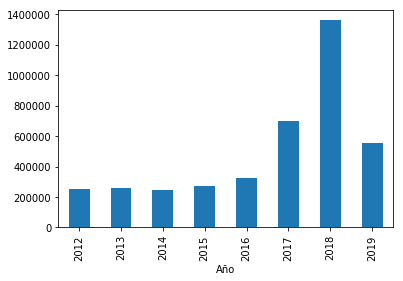

In [17]:
df3.plot(kind='bar')

Gráfica agrupado por género

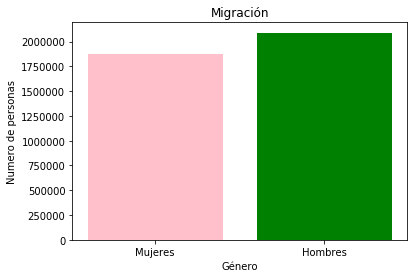

In [18]:
x = ["Mujeres","Hombres"]
y = [df['Femenino'].sum(),df['Masculino'].sum()]

plt.bar(x, y, color=['pink','green'])

plt.title('Migración')
plt.xlabel('Género')
plt.ylabel('Numero de personas')
#plt.savefig('ScatterPlot_03.png')
plt.show()

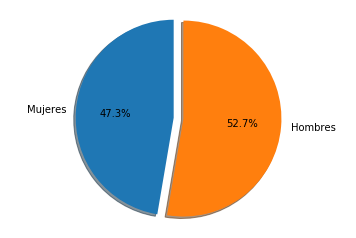

In [19]:
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Unificar gráficos

In [75]:
dfx=pd.DataFrame(columns=['Año','Femenino'])

dfy=df.groupby('Año').sum()
dfy= dfy.drop(columns=['Indefinido','long', 'lat'], axis=1)
dfy

,Femenino,Masculino,Total
Año,,,
2012,113984,137491,251475
2013,117070,144273,261343
2014,107787,137862,245649
2015,124369,148740,273109
2016,148830,174904,323734
2017,320487,377775,698262
2018,658110,701706,1359816
2019,286516,266675,553191


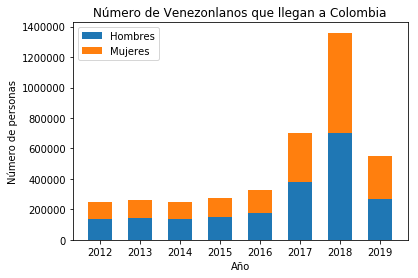

In [86]:
import numpy as np

N = 8
hombres = dfy['Masculino']
mujeres = dfy['Femenino']
hombStd = (2, 3, 4, 1, 2,2,2,2)
mujStd = (3, 5, 2, 3, 3,2,2,2)
ind = np.arange(N)   
width = 0.6       

p1 = plt.bar(ind, hombres, width, yerr=hombStd)
p2 = plt.bar(ind, mujeres, width,
             bottom=hombres, yerr=mujStd)

plt.ylabel('Número de personas')
plt.xlabel('Año')
plt.title('Número de Venezonlanos que llegan a Colombia')
plt.xticks(ind, (df3.index))

plt.legend((p1[0], p2[0]), ('Hombres', 'Mujeres'))

plt.show()

#### Agrupado por mes

In [21]:
df4=df[['Mes','Total']]
df4=df4.groupby(['Mes'])['Total'].sum()
df4

Mes
Abril         350704
Agosto        382701
Diciembre     357805
Enero         363209
Febrero       331027
               ...  
Marzo         316905
Mayo          342949
Noviembre     294935
Octubre       296616
Septiembre    296129
Name: Total, Length: 12, dtype: int64

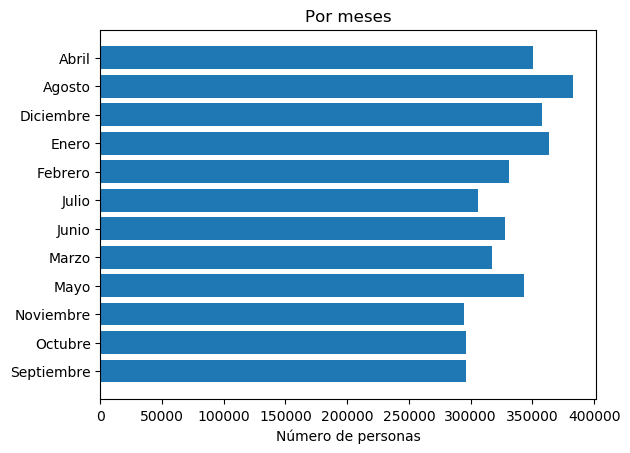

In [92]:
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

meses = df4.index
y_pos = np.arange(len(meses))
performance = df4

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(meses)
ax.invert_yaxis()
ax.set_xlabel('Número de personas')
ax.set_title('Por meses')

plt.show()

### Datos importantes
Como máximo, mínimo, mediana, entre otros datos estadísticos importantes

In [94]:
dfy.describe()

,Femenino,Masculino,Total
count,8.000000,8.000000,8.000000e+00
mean,234644.125000,261178.250000,4.958224e+05
std,190256.584618,197103.160796,3.867902e+05
min,107787.000000,137491.000000,2.456490e+05
25%,116298.500000,142670.250000,2.588760e+05
50%,136599.500000,161822.000000,2.984215e+05
75%,295008.750000,294450.000000,5.894588e+05
max,658110.000000,701706.000000,1.359816e+06


In [23]:
df["Total"].max()

82609

In [24]:
df["Total"].min()

1

In [25]:
df["Total"].mean()

2287.531141868512